In [27]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
url = 'E:\App Exes\VS Code\Proyecto Final Data\healthcare-dataset-stroke-data.csv'

In [28]:
df = pd.read_csv(url, sep = ',')
df = pd.get_dummies(df, columns=['work_type'], prefix='work_type')
df = pd.get_dummies(df, columns=['smoking_status'], prefix='smoking_status')
#Reemplaza valores nulos de BMI promediando por rango edades cercanas
promedio_bmi_edades = df.groupby('age')['bmi'].mean()
df['bmi'] = df.apply(lambda row: promedio_bmi_edades[row['age']] if pd.isnull(row['bmi']) else row['bmi'], axis=1)

#Reemplazo valores strings por valores numericos
df['gender'] = df['gender'].replace({'Male': 1, 'Female': 0, 'Other': 2})
df['ever_married'] = df['ever_married'].replace({'No': 0, 'Yes': 1})
df['Residence_type'] = df['Residence_type'].replace({'Rural': 0, 'Urban': 1})

df_stroke = df.loc[df['stroke'] == 1]
df_nostroke = df.loc[df['stroke'] == 0]

#Muestro el dataframe completo
df

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,1,67.0,0,1,1,1,228.69,36.600000,1,False,False,True,False,False,False,True,False,False
1,51676,0,61.0,0,0,1,0,202.21,30.190000,1,False,False,False,True,False,False,False,True,False
2,31112,1,80.0,0,1,1,0,105.92,32.500000,1,False,False,True,False,False,False,False,True,False
3,60182,0,49.0,0,0,1,1,171.23,34.400000,1,False,False,True,False,False,False,False,False,True
4,1665,0,79.0,1,0,1,0,174.12,24.000000,1,False,False,False,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,0,80.0,1,0,1,1,83.75,28.783582,0,False,False,True,False,False,False,False,True,False
5106,44873,0,81.0,0,0,1,1,125.20,40.000000,0,False,False,False,True,False,False,False,True,False
5107,19723,0,35.0,0,0,1,0,82.99,30.600000,0,False,False,False,True,False,False,False,True,False
5108,37544,1,51.0,0,0,1,0,166.29,25.600000,0,False,False,True,False,False,False,True,False,False


¿Podemos predecir los ACV antes de que ocurran en un paciente?

En este caso como el objetivo del modelo es predecir el porcentaje de posibilidades de que un paciente sufra un ACV, voy a usar un algoritmo de regresion lineal ya que la variable que quiero predecir es continua.

Divido el dataframe en casos mas particulares df_train son casos de no ACV que no tienen ni hipertension ni DVC y casos de ACV con hipertension y/o DCV df_test son los casos restantes en el cual hay casos con ACV sin hipertension ni DVC y casos sin ACV con hipertension y/o DVC

Si no hago esto habrian casos que sufrieron ACV pero no tuvieron hipertension o DCV, esto haria que el modelo no le otorgue el peso necesario a estas variables y luego al predecir un caso con hipertension y/o DCV de pocas posibilidades de ACV.

In [34]:
# Seleccionar pacientes que no tuvieron ACV y no tienen hipertensión ni DVC
cond1 = (df['stroke'] == 0) & (df['hypertension'] == 0) & (df['heart_disease'] == 0)
df1 = df[cond1]

# Seleccionar pacientes que tuvieron ACV y tienen hipertensión o DVC
cond2 = (df['stroke'] == 1) & ((df['hypertension'] == 1) | (df['heart_disease'] == 1))
df2 = df[cond2]

# Concatenar los dos dataframes anteriores
df_train = pd.concat([df1, df2])

In [35]:
# Seleccionar las características y la variable objetivo para df
X_train = df_train[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married','Residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'smoking_status_Unknown', 'smoking_status_formerly smoked',	'smoking_status_never smoked', 'smoking_status_smokes']]
y_train = df_train['stroke']

# Dividir df en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=83)

# Crear el modelo de regresión lineal
reg = LogisticRegression()

# Entrenar el modelo con los datos de entrenamiento de df
reg.fit(X_train, y_train)

# Predecir los valores de stroke para los datos de entrenamiento y prueba de df
train_pred = reg.predict(X_train)
test_pred = reg.predict(X_test)

# Calcular la precisión para los datos de entrenamiento y prueba de df
train_acc = r2_score(y_train, train_pred)
test_acc = r2_score(y_test, test_pred)

# Imprimir los resultados
print("Precisión en datos de entrenamiento:", train_acc)
print("Precisión en datos de prueba:", test_acc)

Precisión en datos de entrenamiento: 1.0
Precisión en datos de prueba: 1.0


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


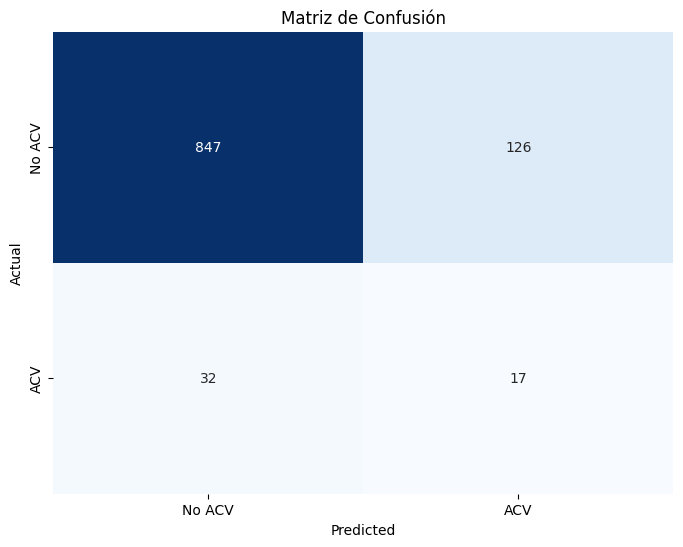

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Seleccionar las características y la variable objetivo para df
X = df[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'smoking_status_Unknown', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']]
y = df['stroke']

# Dividir df en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=83)

# Obtener las predicciones del modelo para los datos de prueba
y_pred = reg.predict(X_test)

# Crear la matriz de confusión
confusion = confusion_matrix(y_test, y_pred)

# Crear un heatmap para visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.xticks([0.5, 1.5], ['No ACV', 'ACV'])
plt.yticks([0.5, 1.5], ['No ACV', 'ACV'])
plt.show()

In [37]:
# Seleccionar las características y la variable objetivo para df
X = df[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'smoking_status_Unknown', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']]
y = df['stroke']

# Dividir df en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=83)

# Crear el modelo de regresión logística
reg = LogisticRegression()

# Entrenar el modelo con los datos de entrenamiento
reg.fit(X_train, y_train)

# Predecir los valores de stroke para los datos de entrenamiento y prueba
train_pred = reg.predict(X_train)
test_pred = reg.predict(X_test)

# Calcular la precisión para los datos de entrenamiento y prueba
train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

print("Precisión en datos de entrenamiento:", train_acc)
print("Precisión en datos de prueba:", test_acc)


Precisión en datos de entrenamiento: 0.9515655577299413
Precisión en datos de prueba: 0.9510763209393346


C:\Users\lucas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


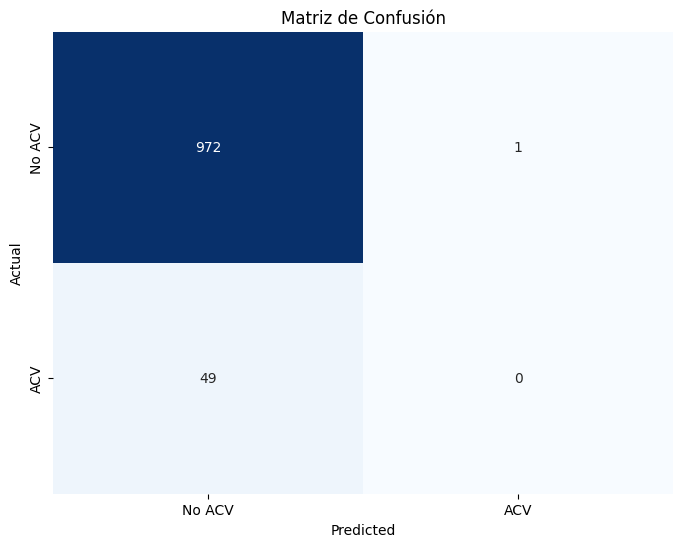

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Seleccionar las características y la variable objetivo para df
X = df[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'smoking_status_Unknown', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']]
y = df['stroke']

# Dividir df en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=83)

# Obtener las predicciones del modelo para los datos de prueba
y_pred = reg.predict(X_test)

# Crear la matriz de confusión
confusion = confusion_matrix(y_test, y_pred)

# Crear un heatmap para visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.xticks([0.5, 1.5], ['No ACV', 'ACV'])
plt.yticks([0.5, 1.5], ['No ACV', 'ACV'])
plt.show()

En el primer modelo, se entrana solo con datos claros para generarle el peso a las variables, en el segundo se usa todo el dataset, en el primer modelo se puede ver que el modelo predice en su mayoria bien pero algunos casos no, estos 126 casos que no tuvieron ACV y el modelo los dio como positivos seguramente tengan hipertension o DCV lo cual los hace realmente propensos al ACV, en cambio en el segundo modelo al no darle peso a estas variables todos los casos excepto 1 dan nnegativo (hay que recordar que de los 5000 pacientes solo 250 tuvieron ACV, pero no significa que no sean propensos al mismo)